In [1]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def concatenate_csv_files(folder_path):
    # List all CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    
    # If no CSV files found, exit
    if not csv_files:
        print("No CSV files found in the folder.")
        return
    
    # Initialize an empty DataFrame to store concatenated data
    concatenated_df = pd.DataFrame()

    # Concatenate all CSV files
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)
        df = df.drop_duplicates(subset=['shot_time', 'COUNTER_ID', 'cycle_time'])
        concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)
    
    return concatenated_df

### Create Ground Truth

In [30]:
ground_truth = concatenate_csv_files('Labelled_Data')
ground_truth = ground_truth[['shot_time', 'COUNTER_ID', 'cycle_time', 'value2']]
ground_truth.rename(columns={'value2': 'ground_truth'}, inplace=True)
ground_truth['ground_truth'] = ground_truth['ground_truth'].apply(lambda x: 0 if x == 2 else 1)
ground_truth['ground_truth'] = 1 - ground_truth['ground_truth'] # Inverting it for clarity 1 means anomoly and 0 means normal (1 is positive class and 0 is negatie class)
ground_truth = ground_truth.drop_duplicates(subset=['shot_time', 'COUNTER_ID', 'cycle_time'])
ground_truth

,shot_time,COUNTER_ID,cycle_time,ground_truth
0,3/21/2024 14:39,EMA2233M10017,57,0
1,3/21/2024 14:40,EMA2233M10017,57,0
2,3/21/2024 14:41,EMA2233M10017,57,0
3,3/21/2024 14:42,EMA2233M10017,57,0
4,3/21/2024 14:43,EMA2233M10017,57,0
...,...,...,...,...
20971,3/21/2024 13:19,EMA2303M10302,32,0
20972,3/21/2024 13:19,EMA2303M10302,31,0
20973,3/21/2024 13:20,EMA2303M10302,32,0
20974,3/21/2024 13:21,EMA2303M10302,32,0


### Rule Base Result Comparison With Ground Truth

In [31]:
rule_base = concatenate_csv_files('aist_result')
rule_base = rule_base[['shot_time', 'COUNTER_ID', 'cycle_time', 'value2']]
rule_base.rename(columns={'value2': 'aist_result'}, inplace=True)
rule_base['aist_result'] = rule_base['aist_result'].apply(lambda x: 0 if x == 2 else 1)
rule_base['aist_result'] = 1 - rule_base['aist_result']
rule_base

,shot_time,COUNTER_ID,cycle_time,aist_result
0,2022-07-07 23:39:24,EMA2227A10005,20,0
1,2022-07-07 23:39:44,EMA2227A10005,20,0
2,2022-07-07 23:40:04,EMA2227A10005,20,0
3,2022-07-07 23:40:25,EMA2227A10005,20,0
4,2022-07-07 23:40:45,EMA2227A10005,20,0
...,...,...,...,...
805211,2023-11-27 13:48:19,EMA2324M10983,1,0
805212,2023-11-27 13:48:21,EMA2324M10983,8,1
805213,2023-11-27 13:48:29,EMA2324M10983,0,0
805214,2023-11-27 13:48:30,EMA2324M10983,9,1


In [32]:
combined_result = pd.merge(ground_truth, rule_base, 
                     on=[
                         'shot_time', 
                         'COUNTER_ID', 
                         'cycle_time'
                         ], 
                     how='inner')
combined_result

,shot_time,COUNTER_ID,cycle_time,ground_truth,aist_result
0,3/21/2024 14:39,EMA2233M10017,57,0,0
1,3/21/2024 14:40,EMA2233M10017,57,0,0
2,3/21/2024 14:41,EMA2233M10017,57,0,0
3,3/21/2024 14:42,EMA2233M10017,57,0,0
4,3/21/2024 14:43,EMA2233M10017,57,0,0
...,...,...,...,...,...
20971,3/21/2024 13:19,EMA2303M10302,32,0,0
20972,3/21/2024 13:19,EMA2303M10302,31,0,0
20973,3/21/2024 13:20,EMA2303M10302,32,0,0
20974,3/21/2024 13:21,EMA2303M10302,32,0,0


### Comparison of Ground Truth vs Rule Based

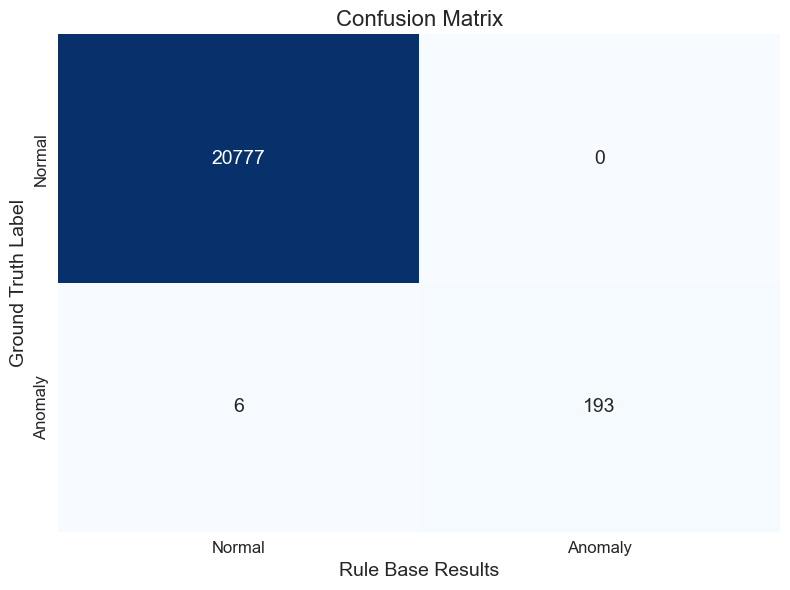

False Positive Rate: 0.00%
False Negative Rate: 3.02%


In [33]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(combined_result['ground_truth'], combined_result['aist_result'])
# Calculate false positive and false negative rates
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
false_negative_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])
# Set seaborn style
sns.set_style("whitegrid")
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Rule Base Results', fontsize=14)
plt.ylabel('Ground Truth Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
# Print false positive and false negative rates
print(f"False Positive Rate: {false_positive_rate:.2%}")
print(f"False Negative Rate: {false_negative_rate:.2%}")

### Isolation Forest Result Comparison With Ground Truth

In [34]:
if_result = concatenate_csv_files('if_results')
if_result

,shot_time,COUNTER_ID,cycle_time,anomoly_score,anomoly_score_inverse,output
0,3/21/2024 14:39,EMA2233M10017,57,0.140314,0.640314,0
1,3/21/2024 14:40,EMA2233M10017,57,0.140314,0.640314,0
2,3/21/2024 14:41,EMA2233M10017,57,0.140314,0.640314,0
3,3/21/2024 14:42,EMA2233M10017,57,0.140314,0.640314,0
4,3/21/2024 14:43,EMA2233M10017,57,0.140314,0.640314,0
...,...,...,...,...,...,...
20971,3/21/2024 13:19,EMA2303M10302,32,0.032960,0.532960,0
20972,3/21/2024 13:19,EMA2303M10302,31,0.045250,0.545250,0
20973,3/21/2024 13:20,EMA2303M10302,32,0.032960,0.532960,0
20974,3/21/2024 13:21,EMA2303M10302,32,0.032960,0.532960,0


In [35]:
combined_result = pd.merge(ground_truth, if_result, 
                     on=[
                         'shot_time', 
                         'COUNTER_ID', 
                         'cycle_time'
                         ], 
                     how='inner')
combined_result

,shot_time,COUNTER_ID,cycle_time,ground_truth,anomoly_score,anomoly_score_inverse,output
0,3/21/2024 14:39,EMA2233M10017,57,0,0.140314,0.640314,0
1,3/21/2024 14:40,EMA2233M10017,57,0,0.140314,0.640314,0
2,3/21/2024 14:41,EMA2233M10017,57,0,0.140314,0.640314,0
3,3/21/2024 14:42,EMA2233M10017,57,0,0.140314,0.640314,0
4,3/21/2024 14:43,EMA2233M10017,57,0,0.140314,0.640314,0
...,...,...,...,...,...,...,...
20971,3/21/2024 13:19,EMA2303M10302,32,0,0.032960,0.532960,0
20972,3/21/2024 13:19,EMA2303M10302,31,0,0.045250,0.545250,0
20973,3/21/2024 13:20,EMA2303M10302,32,0,0.032960,0.532960,0
20974,3/21/2024 13:21,EMA2303M10302,32,0,0.032960,0.532960,0


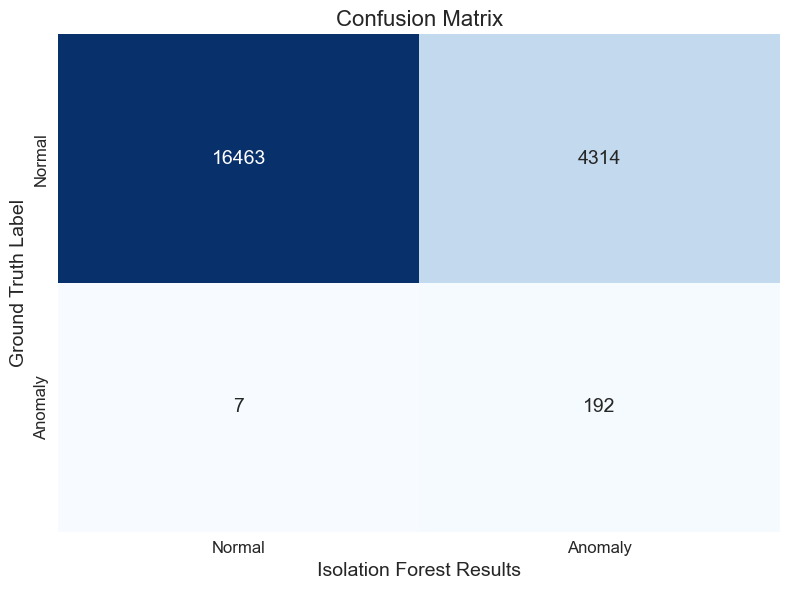

False Positive Rate: 20.76%
False Negative Rate: 3.52%


In [36]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(combined_result['ground_truth'], combined_result['output'])
# Calculate false positive and false negative rates
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
false_negative_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])
# Set seaborn style
sns.set_style("whitegrid")
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Isolation Forest Results', fontsize=14)
plt.ylabel('Ground Truth Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
# Print false positive and false negative rates
print(f"False Positive Rate: {false_positive_rate:.2%}")
print(f"False Negative Rate: {false_negative_rate:.2%}")

# ELECTROLUX DATA

### Create Ground Truth

In [4]:
ground_truth = concatenate_csv_files('labelled_data_electrolux')
ground_truth = ground_truth.dropna(subset='cycle_time')
ground_truth = ground_truth[['shot_time', 'COUNTER_ID', 'cycle_time', 'GT_Anomaly']]
ground_truth.rename(columns={'GT_Anomaly': 'ground_truth'}, inplace=True)
# ground_truth['ground_truth'] = ground_truth['ground_truth'].astype(int)
ground_truth['ground_truth'] = ground_truth['ground_truth'].replace('`1', '1')
ground_truth['ground_truth'] = ground_truth['ground_truth'].astype(int)
ground_truth

,shot_time,COUNTER_ID,cycle_time,ground_truth
0,2022-02-21 13:19:08,EMA2233M10295,3.0,1
1,2022-02-21 13:19:11,EMA2233M10295,0.0,1
2,2022-02-21 13:19:12,EMA2233M10295,155.0,1
3,2022-02-21 13:21:46,EMA2233M10295,14.0,1
4,2022-02-21 13:22:00,EMA2233M10295,4.0,1
...,...,...,...,...
140218,2023-12-21 18:47:09,EMA2233M10308,59.0,0
140219,2023-12-21 18:48:08,EMA2233M10308,58.0,0
140220,2023-12-21 18:49:06,EMA2233M10308,196.0,1
140221,2024-01-25 07:50:47,EMA2233M10308,10.0,1


### Rule Base Result Comparison With Ground Truth

In [5]:
rule_base = concatenate_csv_files('aist_resut_ver2_electrolux')
rule_base = rule_base[['shot_time', 'COUNTER_ID', 'cycle_time', 'value2']]
rule_base.rename(columns={'value2': 'aist_result'}, inplace=True)
rule_base['aist_result'] = rule_base['aist_result'].apply(lambda x: 0 if x == 2 else 1)
rule_base['aist_result'] = 1 - rule_base['aist_result']
rule_base

,shot_time,COUNTER_ID,cycle_time,aist_result
0,2022-02-21 13:19:08,EMA2233M10295,3,0
1,2022-02-21 13:19:11,EMA2233M10295,0,0
2,2022-02-21 13:19:12,EMA2233M10295,155,1
3,2022-02-21 13:21:46,EMA2233M10295,14,1
4,2022-02-21 13:22:00,EMA2233M10295,4,0
...,...,...,...,...
140218,2023-12-21 12:19:05,EMA2233M10308,58,0
140219,2023-12-21 12:20:03,EMA2233M10308,58,0
140220,2023-12-21 12:21:02,EMA2233M10308,226,1
140221,2024-01-25 07:50:47,EMA2233M10308,10,0


In [6]:
combined_result = pd.merge(ground_truth, rule_base, 
                     on=['shot_time', 
                         'COUNTER_ID', 
                         'cycle_time'], 
                     how='inner')
combined_result

,shot_time,COUNTER_ID,cycle_time,ground_truth,aist_result
0,2022-02-21 13:19:08,EMA2233M10295,3.0,1,0
1,2022-02-21 13:19:11,EMA2233M10295,0.0,1,0
2,2022-02-21 13:19:12,EMA2233M10295,155.0,1,1
3,2022-02-21 13:21:46,EMA2233M10295,14.0,1,1
4,2022-02-21 13:22:00,EMA2233M10295,4.0,1,0
...,...,...,...,...,...
140218,2023-12-21 18:47:09,EMA2233M10308,59.0,0,0
140219,2023-12-21 18:48:08,EMA2233M10308,58.0,0,0
140220,2023-12-21 18:49:06,EMA2233M10308,196.0,1,1
140221,2024-01-25 07:50:47,EMA2233M10308,10.0,1,0


### Comparison of Ground Truth vs Rule Based

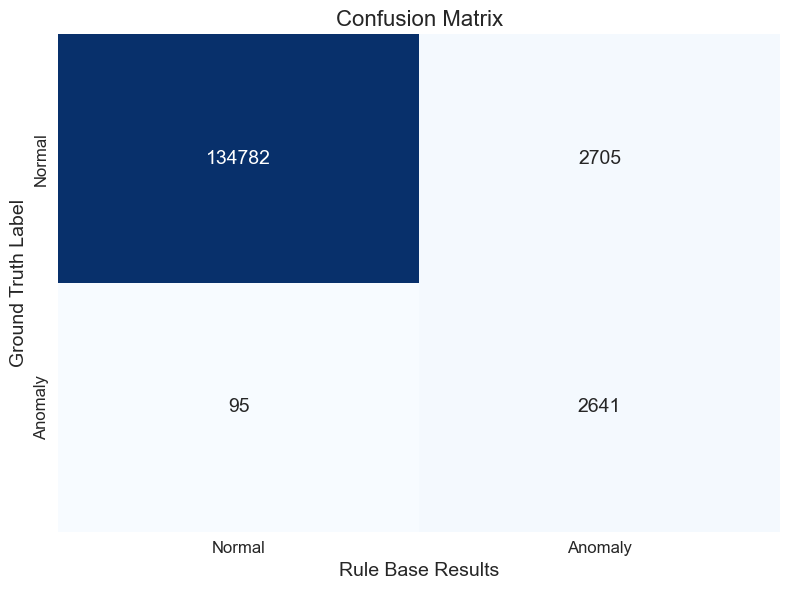

False Positive Rate: 1.97%
False Negative Rate: 3.47%


In [7]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(combined_result['ground_truth'], combined_result['aist_result'])
# Calculate false positive and false negative rates
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
false_negative_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])
# Set seaborn style
sns.set_style("whitegrid")
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Rule Base Results', fontsize=14)
plt.ylabel('Ground Truth Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
# Print false positive and false negative rates
print(f"False Positive Rate: {false_positive_rate:.2%}")
print(f"False Negative Rate: {false_negative_rate:.2%}")

### Isolation Forest Result Comparison With Ground Truth

In [8]:
if_result = concatenate_csv_files('if_results_electrolux')
if_result

,shot_time,COUNTER_ID,cycle_time,anomoly_score,anomoly_score_inverse,output
0,2022-02-21 13:19:08,EMA2233M10295,3,-0.238020,0.261980,1
1,2022-02-21 13:19:11,EMA2233M10295,0,-0.238020,0.261980,1
2,2022-02-21 13:19:12,EMA2233M10295,155,-0.320677,0.179323,1
3,2022-02-21 13:21:46,EMA2233M10295,14,-0.232548,0.267452,1
4,2022-02-21 13:22:00,EMA2233M10295,4,-0.238020,0.261980,1
...,...,...,...,...,...,...
140218,2023-12-21 12:19:05,EMA2233M10308,58,0.133198,0.633198,0
140219,2023-12-21 12:20:03,EMA2233M10308,58,0.133198,0.633198,0
140220,2023-12-21 12:21:02,EMA2233M10308,226,-0.302064,0.197936,1
140221,2024-01-25 07:50:47,EMA2233M10308,10,-0.192712,0.307288,1


In [9]:
combined_result = pd.merge(ground_truth, if_result, 
                     on=[
                         'shot_time', 
                         'COUNTER_ID', 
                         'cycle_time'
                         ], 
                     how='inner')
combined_result

,shot_time,COUNTER_ID,cycle_time,ground_truth,anomoly_score,anomoly_score_inverse,output
0,2022-02-21 13:19:08,EMA2233M10295,3.0,1,-0.238020,0.261980,1
1,2022-02-21 13:19:11,EMA2233M10295,0.0,1,-0.238020,0.261980,1
2,2022-02-21 13:19:12,EMA2233M10295,155.0,1,-0.320677,0.179323,1
3,2022-02-21 13:21:46,EMA2233M10295,14.0,1,-0.232548,0.267452,1
4,2022-02-21 13:22:00,EMA2233M10295,4.0,1,-0.238020,0.261980,1
...,...,...,...,...,...,...,...
140218,2023-12-21 18:47:09,EMA2233M10308,59.0,0,0.093769,0.593769,0
140219,2023-12-21 18:48:08,EMA2233M10308,58.0,0,0.133198,0.633198,0
140220,2023-12-21 18:49:06,EMA2233M10308,196.0,1,-0.287012,0.212988,1
140221,2024-01-25 07:50:47,EMA2233M10308,10.0,1,-0.192712,0.307288,1


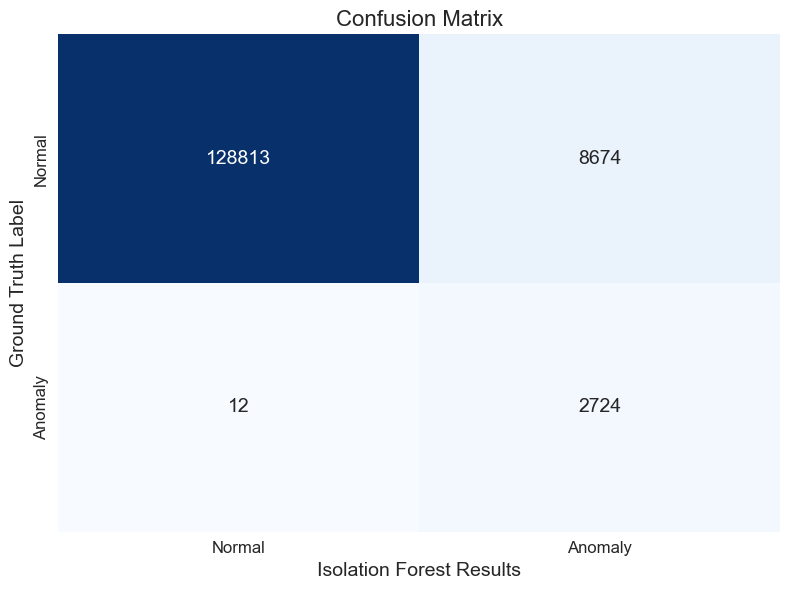

False Positive Rate: 6.31%
False Negative Rate: 0.44%


In [10]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(ground_truth['ground_truth'], combined_result['output'])
# Calculate false positive and false negative rates
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
false_negative_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])
# Set seaborn style
sns.set_style("whitegrid")
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Isolation Forest Results', fontsize=14)
plt.ylabel('Ground Truth Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
# Print false positive and false negative rates
print(f"False Positive Rate: {false_positive_rate:.2%}")
print(f"False Negative Rate: {false_negative_rate:.2%}")